In [1]:
import sys
import os

%load_ext autoreload
%autoreload 2

sys.path.append('../')
sys.path.insert(0, os.path.dirname(os.getcwd()) + "/../")

print(sys.path)

['/home/hieutt/electricity_theft_detection/../', '/home/hieutt/electricity_theft_detection/notebooks', '/home/hieutt/miniconda3/envs/torchtf/lib/python39.zip', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/lib-dynload', '', '/home/hieutt/miniconda3/envs/torchtf/lib/python3.9/site-packages', '../']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================
# PHẦN 1: HÀM LOAD & XỬ LÝ (GIỮ NGUYÊN)
# ==========================================
def load_halfhour_txt(path):
    return pd.read_csv(path, sep=r"\s+", header=None, names=["id", "slot", "kwh"])

def halfhour_to_hourly(df_one_id):
    df_one_id = df_one_id.sort_values('slot')
    base = df_one_id['slot'].min()
    hour_idx = ((df_one_id['slot'] - base) // 2).astype(int)
    hh = (df_one_id.assign(hour_idx=hour_idx)
          .groupby('hour_idx', as_index=False)['kwh'].mean())
    return hh

def hourly_to_daily_24(hh):
    hh = hh.sort_values('hour_idx')
    day_idx = (hh['hour_idx'] // 24).to_numpy()
    hour_in_day = (hh['hour_idx'] % 24).to_numpy()
    kwh = hh['kwh'].to_numpy()
    days = {}
    for d, h, v in zip(day_idx, hour_in_day, kwh):
        days.setdefault(d, np.full(24, np.nan, dtype=float))
        days[d][h] = v
    X = []
    for d in sorted(days.keys()):
        vec = days[d]
        if np.isfinite(vec).sum() == 24:
            X.append(vec.astype(float))
    if not X: return np.empty((0, 24), dtype=float)
    return np.stack(X, axis=0)

def build_benign_from_folder(folder):
    all_benign = []
    if not os.path.exists(folder):
        print(f"Folder {folder} not found!")
        return np.empty((0, 24), dtype=float)
    for fname in sorted(os.listdir(folder)):
        if not fname.lower().endswith('.txt'): continue
        df = load_halfhour_txt(os.path.join(folder, fname))
        for cid, g in df.groupby('id'):
            hh = halfhour_to_hourly(g[['slot', 'kwh']].copy())
            X = hourly_to_daily_24(hh)
            if len(X) > 0: all_benign.append(X)
    if not all_benign: return np.empty((0, 24), dtype=float)
    return np.vstack(all_benign)

In [ ]:
# # ==========================================
# # PHẦN 2: ĐỊNH NGHĨA 6 LOẠI ATTACK
# # ==========================================
# _rng_global = np.random.default_rng(42)

# def atk_h1_scale_down(x, rng=None): 
#     rng = _rng_global if rng is None else rng
#     return rng.uniform(0.1, 0.8) * x

# def atk_h2_zero_random_hours(x, rng=None):
#     rng = _rng_global if rng is None else rng
#     x2 = x.copy()
#     n_zero = int(rng.integers(3, 9))
#     idx = rng.choice(24, size=n_zero, replace=False)
#     x2[idx] = 0.0
#     return x2

# def atk_h3_rand_scale_per_hour(x, rng=None):
#     rng = _rng_global if rng is None else rng
#     gamma = rng.uniform(0.1, 0.8, size=24)
#     return gamma * x

# def atk_h4_mean_scaled(x, rng=None):
#     rng = _rng_global if rng is None else rng
#     mu = x.mean()
#     gamma = rng.uniform(0.1, 0.8, size=24)
#     return gamma * mu

# def atk_h5_mean_flat(x):
#     mu = x.mean()
#     return np.full(24, mu, dtype=float)

# def atk_h6_reverse_day(x):
#     return x[::-1].copy()

# ATK_FUNCS = {
#     1: atk_h1_scale_down, 2: atk_h2_zero_random_hours,
#     3: atk_h3_rand_scale_per_hour, 4: atk_h4_mean_scaled,
#     5: atk_h5_mean_flat, 6: atk_h6_reverse_day,
# }

In [ ]:
import numpy as np

# ==========================================
# PHẦN 2: ĐỊNH NGHĨA 6 LOẠI ATTACK 
# ==========================================
_rng_global = np.random.default_rng(42)

def atk_h1_scale_down(x, rng=None): 
    rng = _rng_global if rng is None else rng
    beta = rng.uniform(0.1, 0.4) 
    return beta * x

def atk_h2_rand_scale_per_hour(x, rng=None):
    rng = _rng_global if rng is None else rng
    
    gamma = rng.uniform(0.05, 0.5, size=24) 
    
    return gamma * x

def atk_h3_mean_flat(x):
    mu = x.mean()
    return np.full(24, mu, dtype=float)

def atk_h4_mean_scaled(x, rng=None):
    rng = _rng_global if rng is None else rng
    mu = x.mean()
    # Bài báo ghi beta_t (time-varying), nên ta sinh vector ngẫu nhiên
    gamma = rng.uniform(0.1, 0.4, size=24) 
    return gamma * mu

def atk_h5_zero_interval(x, rng=None):
    rng = _rng_global if rng is None else rng
    x2 = x.copy()
    
    # Chọn thời điểm bắt đầu cắt điện (t_s)
    # Bài báo: t_s in [0, 19] cho 48 slots -> Tương đương [0, ~9] cho 24 slots
    t_start = rng.integers(0, 10) 
    
    # Cắt từ t_start đến hết ngày (t_e = 24)
    x2[t_start:] = 0.0
    return x2

def atk_h6_reverse_day(x):
    return x[::-1].copy()

# Cập nhật lại Dict ánh xạ theo đúng thứ tự bài báo
ATK_FUNCS = {
    1: atk_h1_scale_down,           # Attack 1
    2: atk_h2_rand_scale_per_hour,  # Attack 2 (Code cũ là h3)
    3: atk_h3_mean_flat,            # Attack 3 (Code cũ là h5)
    4: atk_h4_mean_scaled,          # Attack 4
    5: atk_h5_zero_interval,        # Attack 5 (Code cũ là h2 nhưng logic khác)
    6: atk_h6_reverse_day,          # Attack 6
}

In [6]:
# ==========================================
# PHẦN 3: SINH DATA MULTI-CLASS 
# ==========================================
def gen_attacks_quota(X_base, atk_id, n_target, seed):
    fn = ATK_FUNCS[atk_id]
    rng_local = np.random.default_rng(seed)
    outs = []
    
    # Danh sách các attack cần tham số ngẫu nhiên rng
    # Attack 1 (Scale Down), 2 (Rand Scale), 4 (Mean Scaled), 5 (Zero Interval) -> Cần RNG
    # Attack 3 (Mean Flat), 6 (Reverse) -> Không cần RNG (vì nó cố định theo input)
    NEEDS_RNG = [1, 2, 4, 5] 
    
    while sum(len(o) for o in outs) < n_target:
        seeds = rng_local.integers(1<<30, size=len(X_base))
        batch_atk = []
        for i, x in enumerate(X_base):
            s_i = np.random.default_rng(seeds[i])
            
            # [FIXED] Kiểm tra đúng ID attack cần rng
            if atk_id in NEEDS_RNG:
                batch_atk.append(fn(x, rng=s_i))
            else:
                batch_atk.append(fn(x))
                
        outs.append(np.vstack(batch_atk).astype(np.float32))
        if len(X_base) == 0: break
        
    A_all = np.vstack(outs)
    if len(A_all) > n_target:
        sel = np.random.default_rng(seed+1).choice(len(A_all), size=n_target, replace=False)
        A_all = A_all[sel]
    return A_all

In [ ]:
# ---- BẮT ĐẦU ----
folder = '../data/CER_ETD'
X_benign_raw = build_benign_from_folder(folder)
print(f'Original Benign Pool: {X_benign_raw.shape}')

# 1. Global Normalization (BẮT BUỘC cho Multi-class H1/H4)
global_max = X_benign_raw.max()
global_min = X_benign_raw.min()
print(f"Global Max: {global_max:.4f}, Global Min: {global_min:.4f}")

def normalize_global(X, g_min, g_max):
    return (X - g_min) / (g_max - g_min + 1e-9)

X_benign = normalize_global(X_benign_raw, global_min, global_max)

SEED_SPLIT = 123
rng = np.random.default_rng(SEED_SPLIT)
N = len(X_benign)
idx = np.arange(N)
rng.shuffle(idx)

cut = int(round(N * 0.7))
idx_train_pool = idx[:cut] # Index dùng cho Train
idx_test_pool = idx[cut:]  # Index dùng cho Val

# ==========================================
# A. TẠO TẬP TRAIN (BALANCED - CÂN BẰNG)
# ==========================================
print("--- Generating Training Set (Balanced) ---")
# Cấu hình: Mỗi lớp có số lượng bằng nhau
SAMPLES_PER_CLASS_TRAIN = 6000 

# 1. Class 0: Benign
# Lấy ngẫu nhiên từ pool train
X_train_benign = X_benign[rng.choice(idx_train_pool, size=SAMPLES_PER_CLASS_TRAIN, replace=False)]
train_X_list = [X_train_benign]
train_y_list = [np.zeros(len(X_train_benign), dtype=np.int64)]

# 2. Class 1-6: Attacks
# Sinh từ pool train benign để đảm bảo tính nhất quán của tập train
X_train_pool_all = X_benign[idx_train_pool] 

for aid in range(1, 7):
    # Sinh đủ quota
    A = gen_attacks_quota(X_train_pool_all, aid, SAMPLES_PER_CLASS_TRAIN, seed=1000+aid)
    train_X_list.append(A)
    train_y_list.append(np.full(len(A), aid, dtype=np.int64)) # Label 1..6

# Gộp lại
X_tr = np.vstack(train_X_list).astype(np.float32)
y_tr = np.concatenate(train_y_list).astype(np.int64)

# ==========================================
# B. TẠO TẬP VAL (IMBALANCED & RANDOMIZED)
# ==========================================
print("\n--- Generating Validation Set (Imbalanced & Random) ---")

# Lấy pool data cho validation
X_val_pool_all = X_benign[idx_test_pool]

val_X_list = []
val_y_list = []

# 1. Class 0: Benign
# Chọn một số lượng lớn tùy ý (ví dụ 6000) để làm nền
N_VAL_BENIGN = 6000
# Đảm bảo không lấy quá số lượng pool đang có
N_VAL_BENIGN = min(N_VAL_BENIGN, len(X_val_pool_all))

# Lấy mẫu Benign cho Val
X_val_benign = X_benign[rng.choice(idx_test_pool, size=N_VAL_BENIGN, replace=False)]
val_X_list.append(X_val_benign)
val_y_list.append(np.zeros(len(X_val_benign), dtype=np.int64))
print(f"  Class 0 (Benign): {len(X_val_benign)} samples")

# 2. Class 1-6: Attacks (Random 1000 - 2000)
rng_val_counts = np.random.default_rng(seed=999) # Seed riêng cho việc random số lượng

for aid in range(1, 7):
    # Random số lượng từ 1000 đến 2000
    n_target = rng_val_counts.integers(1000, 2001)
    
    # Sinh attack từ pool validation (để đảm bảo unseen data)
    A = gen_attacks_quota(X_val_pool_all, aid, n_target, seed=2000+aid)
    
    val_X_list.append(A)
    val_y_list.append(np.full(len(A), aid, dtype=np.int64))
    print(f"  Class {aid} (Attack): {len(A)} samples (Randomized)")

# Gộp lại
X_te = np.vstack(val_X_list).astype(np.float32)
y_te = np.concatenate(val_y_list).astype(np.int64)

# ==========================================
# C. SHUFFLE & SAVE
# ==========================================
def shuffle_data(X, y, seed):
    r = np.random.default_rng(seed)
    i = r.permutation(len(X))
    return X[i], y[i]

# Shuffle
X_tr, y_tr = shuffle_data(X_tr, y_tr, seed=777)
X_te, y_te = shuffle_data(X_te, y_te, seed=888)

# In thống kê cuối cùng
print("\n=== FINAL DATASET STATISTICS ===")
print(f"TRAIN Set Total: {X_tr.shape[0]}")
for c in range(7):
    count = (y_tr == c).sum()
    print(f"  - Class {c}: {count} samples ({count/len(y_tr)*100:.2f}%)")

print(f"\nVAL Set Total: {X_te.shape[0]}")
for c in range(7):
    count = (y_te == c).sum()
    print(f"  - Class {c}: {count} samples ({count/len(y_te)*100:.2f}%)")

# Lưu file
out_dir = './prepared_etd_multiclass'
os.makedirs(out_dir, exist_ok=True)
np.savez(os.path.join(out_dir, 'train.npz'), data=X_tr, label=y_tr) 
np.savez(os.path.join(out_dir, 'val.npz'),  data=X_te, label=y_te)
print(f"\nData saved to {out_dir}")

Original Benign Pool: (276630, 24)
Global Max: 50.7535, Global Min: 0.0000
--- Generating Training Set (Balanced) ---

--- Generating Validation Set (Imbalanced & Random) ---
  Class 0 (Benign): 6000 samples
  Class 1 (Attack): 1814 samples (Randomized)
  Class 2 (Attack): 1779 samples (Randomized)
  Class 3 (Attack): 1174 samples (Randomized)
  Class 4 (Attack): 1172 samples (Randomized)
  Class 5 (Attack): 1181 samples (Randomized)
  Class 6 (Attack): 1714 samples (Randomized)

=== FINAL DATASET STATISTICS ===
TRAIN Set Total: 21000
  - Class 0: 3000 samples (14.29%)
  - Class 1: 3000 samples (14.29%)
  - Class 2: 3000 samples (14.29%)
  - Class 3: 3000 samples (14.29%)
  - Class 4: 3000 samples (14.29%)
  - Class 5: 3000 samples (14.29%)
  - Class 6: 3000 samples (14.29%)

VAL Set Total: 14834
  - Class 0: 6000 samples (40.45%)
  - Class 1: 1814 samples (12.23%)
  - Class 2: 1779 samples (11.99%)
  - Class 3: 1174 samples (7.91%)
  - Class 4: 1172 samples (7.90%)
  - Class 5: 1181 s

Visualizing Data Patterns...


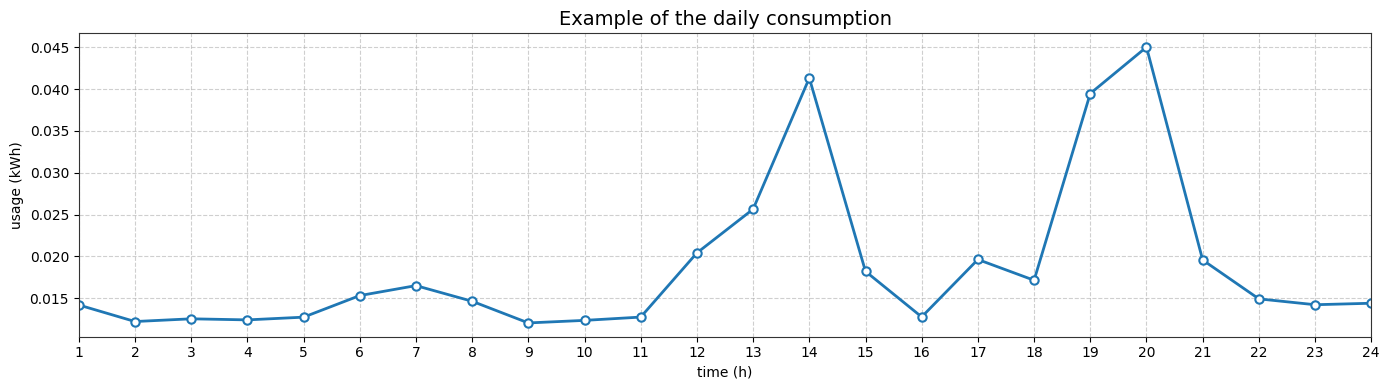

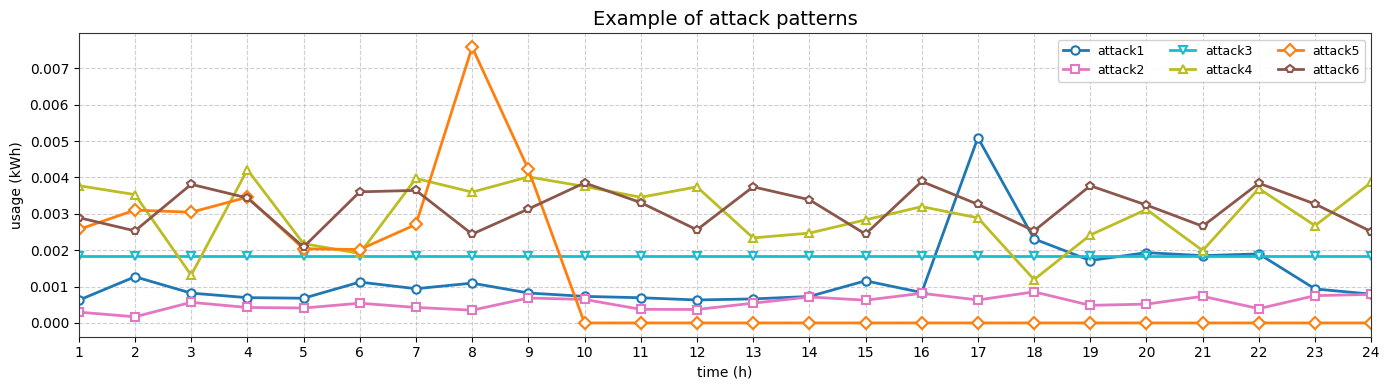

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Cấu hình style để giống hình mẫu (nền trắng, lưới đứt đoạn, font rõ)
plt.rcParams.update({
    "axes.grid": True,
    "grid.linestyle": "--",
    "grid.alpha": 0.6,
    "axes.spines.top": True,    # Giữ khung trên
    "axes.spines.right": True,  # Giữ khung phải
    "axes.edgecolor": "#333333",
    "font.size": 10,
    "legend.frameon": True,
    "legend.framealpha": 0.9,
    "figure.figsize": (14, 4),  # Tỉ lệ khung hình rộng (wide)
    "lines.linewidth": 2.0,
    "lines.markersize": 6,
    "lines.markeredgewidth": 1.5,
})

def visualize_comparison_patterns(X, y):
    """
    Vẽ 2 hình riêng biệt:
    1. Một mẫu Benign (Class 0)
    2. Tổng hợp 6 mẫu Attack (Class 1-6) trên cùng một biểu đồ
    """
    hours = np.arange(1, 25) # Trục X từ 1 đến 24
    rng_viz = np.random.default_rng() # Random generator
    
    # --- FIGURE 1: BENIGN ONLY ---
    plt.figure(figsize=(14, 4))
    
    # Lấy 1 mẫu Benign ngẫu nhiên
    idx_benign = np.where(y == 0)[0]
    if len(idx_benign) > 0:
        idx = rng_viz.choice(idx_benign)
        sample = X[idx]
        
        plt.plot(hours, sample, 
                 color='#1f77b4',       # Màu xanh dương chuẩn
                 marker='o',            # Hình tròn
                 markerfacecolor='white', # Ruột trắng (giống hình mẫu)
                 label='Benign')
        
    plt.title("Example of the daily consumption", fontsize=14)
    plt.xlabel("time (h)")
    plt.ylabel("usage (kWh)")
    plt.xlim(1, 24)
    plt.xticks(np.arange(1, 25))
    plt.tight_layout()
    plt.show()
    
    # --- FIGURE 2: ALL ATTACKS COMBINED ---
    plt.figure(figsize=(14, 4))
    
    # Định nghĩa màu và marker riêng cho từng loại attack để dễ phân biệt
    styles = {
        1: {'color': '#1f77b4', 'marker': 'o', 'label': 'attack1'}, # Xanh dương - Tròn
        2: {'color': '#e377c2', 'marker': 's', 'label': 'attack2'}, # Hồng - Vuông
        3: {'color': '#17becf', 'marker': 'v', 'label': 'attack3'}, # Cyan - Tam giác ngược
        4: {'color': '#bcbd22', 'marker': '^', 'label': 'attack4'}, # Olive - Tam giác xuôi
        5: {'color': '#ff7f0e', 'marker': 'D', 'label': 'attack5'}, # Cam - Kim cương
        6: {'color': '#8c564b', 'marker': 'p', 'label': 'attack6'}  # Nâu - Ngũ giác
    }
    
    has_data = False
    for aid in range(1, 7):
        idxs = np.where(y == aid)[0]
        if len(idxs) > 0:
            idx = rng_viz.choice(idxs)
            sample = X[idx]
            s = styles[aid]
            
            plt.plot(hours, sample, 
                     color=s['color'], 
                     marker=s['marker'],
                     markerfacecolor='white', # Ruột trắng
                     label=s['label'])
            has_data = True
            
    if has_data:
        plt.title("Example of attack patterns", fontsize=14)
        plt.xlabel("time (h)")
        plt.ylabel("usage (kWh)")
        plt.xlim(1, 24)
        plt.xticks(np.arange(1, 25))
        # Legend chia làm 3 cột, nằm góc trên
        plt.legend(ncol=3, loc='upper right', fontsize=9)
        
    plt.tight_layout()
    plt.show()

# --- CHẠY VISUALIZE ---
print("Visualizing Data Patterns...")
# Đảm bảo bạn truyền đúng X_tr (Train Data) và y_tr (Label) vào hàm
visualize_comparison_patterns(X_tr, y_tr)